# Data Preparation

In [181]:
# import library
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
import pandas as pd
import numpy as np
import math as mh

In [182]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-16828617.py:2: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


In [183]:
l = [data[:, [i]] for i in range(len(data[0]))]
description = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]

In [184]:
nrows = mh.ceil(len(data[0])/2)

Text(0, 0.5, 'Price')

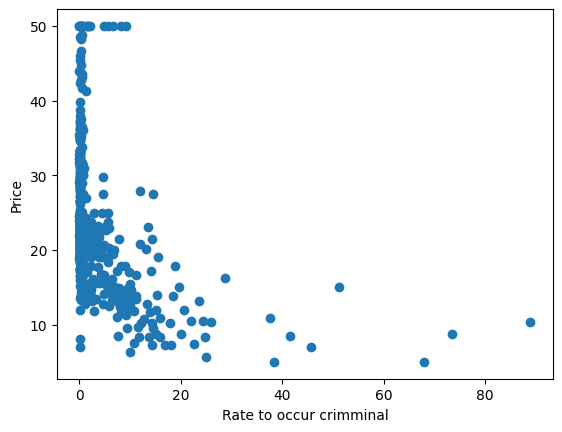

In [185]:
plt.scatter(l[0], target)
plt.xlabel("Rate to occur crimminal")
plt.ylabel("Price")

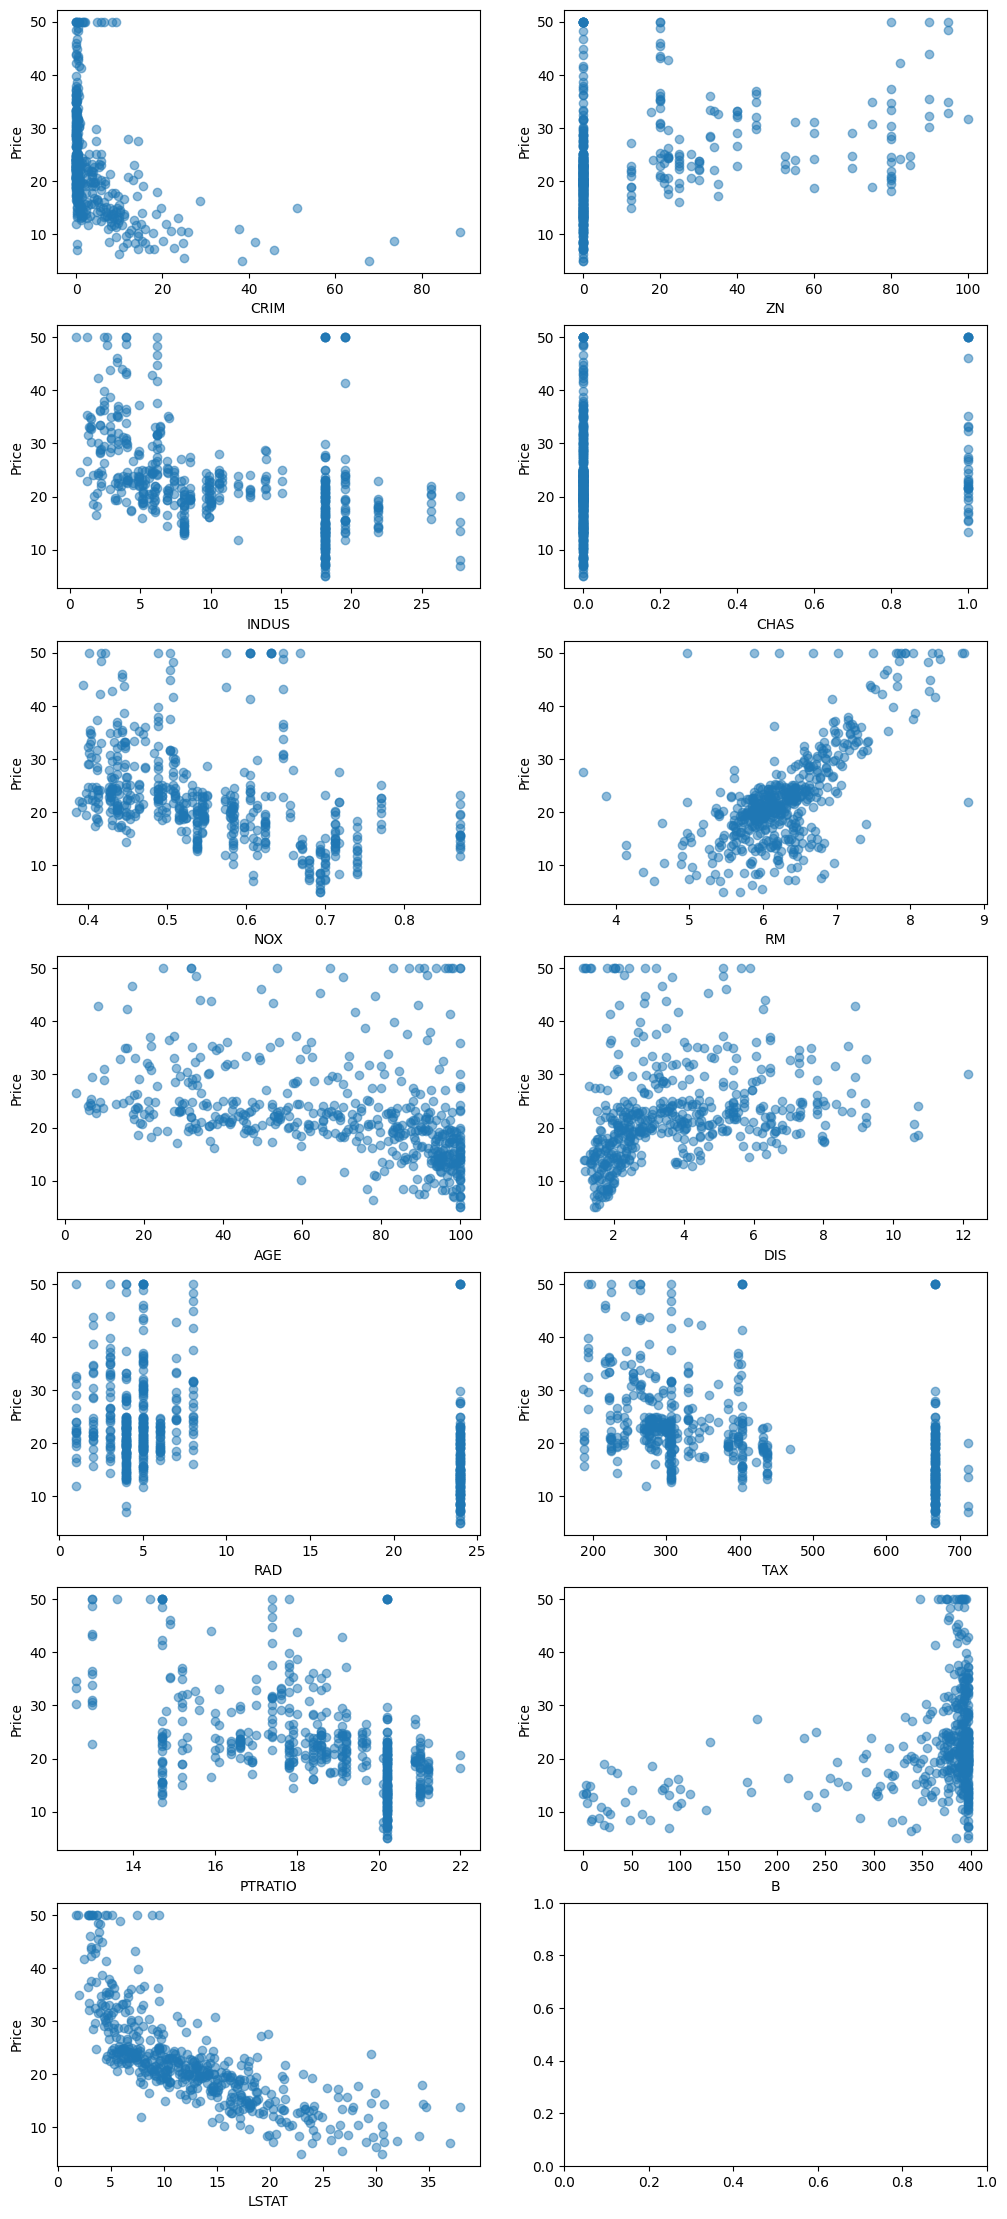

In [186]:
_, ax = plt.subplots(nrows, 2, figsize=(12, nrows*4))

for i in range(len(data[0])):
    row = i // 2
    col = i % 2

    ax[row, col].scatter(l[i], target, alpha=0.5)
    ax[row, col].set_xlabel(description[i])
    ax[row, col].set_ylabel("Price")

In [187]:
# Phase preprocessing data
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer

In [188]:
poly2 = PolynomialFeatures(degree=2, include_bias=False)
parabola = FunctionTransformer(lambda x: (x**2 - 30 ) + 5)

In [189]:
RM_2 = poly2.fit_transform(l[5])
LStat = parabola.fit_transform(l[12])

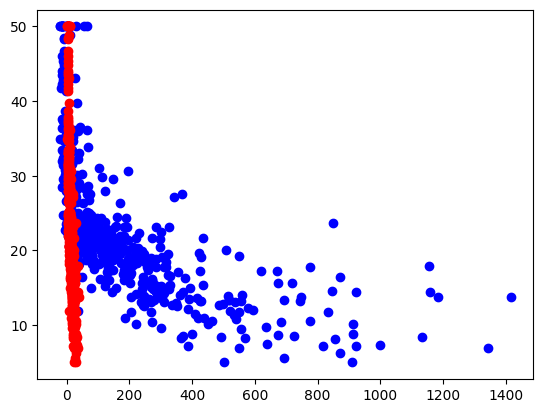

In [190]:
plt.scatter(LStat, target, color="blue")
plt.scatter(l[12], target, color="red")

In [191]:
train_data = np.hstack([RM_2, LStat])
train_data

array([[ 6.575   , 43.230625, -0.1996  ],
       [ 6.421   , 41.229241, 58.5396  ],
       [ 7.185   , 51.624225, -8.7591  ],
       ...,
       [ 6.976   , 48.664576,  6.8096  ],
       [ 6.794   , 46.158436, 16.9904  ],
       [ 6.03    , 36.3609  , 37.0944  ]])

# Enhance Model

In [192]:
model = linear_model.LinearRegression()

In [193]:
model.fit(train_data, target)

LinearRegression()

In [194]:
print(model.coef_, model.intercept_)

[-3.76863044e+01  3.39033959e+00 -1.75568648e-02] 127.0655315673908


In [195]:
result = model.predict(train_data)

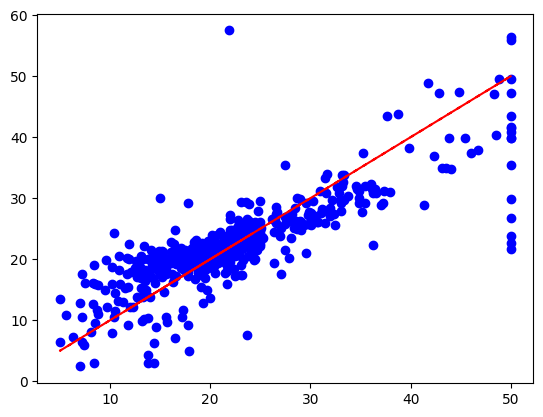

In [196]:
plt.plot(target, target, linestyle="--", color="red")
plt.scatter(target, result, color="blue")

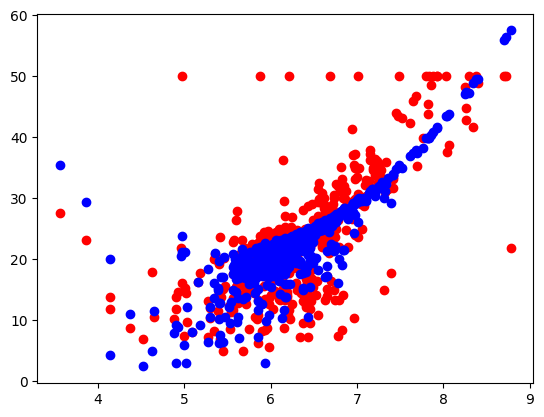

In [197]:
plt.scatter(l[5], target, color="red")
plt.scatter(l[5], result, color="blue")

# Model Evaluation

In [261]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [262]:
RAND_STATE=123

In [263]:
X = data[:, [12]]
Y = target
# Use only LSTAT feature

In [264]:
error_train = dict()
error_val = dict()
poly = dict()
models = dict()

In [265]:
def generate_model(alpha=0):
  for deg in range(1,13):
    model_name = "poly"+str(deg)
    poly[model_name] = PolynomialFeatures(degree=deg, include_bias=False)

    # Cross validation
    error_train[model_name] = []
    error_val[model_name] = []
    kf = KFold(n_splits=5, shuffle=True, random_state=RAND_STATE)
    for train_index, val_index in kf.split(X):
      x_train, y_train = X[train_index], Y[train_index]
      x_test, y_test = X[val_index], Y[val_index]

      # x_train_transform = poly[model_name].fit_transform(x_train)
      # x_test_transform = poly[model_name].transform(x_test)

      # scaler = StandardScaler()
      # x_train_transform = scaler.fit_transform(x_train_transform)
      # x_test_transform = scaler.transform(x_test_transform)
      # model pipeline
      model = make_pipeline(
          poly[model_name],
          StandardScaler(),
          linear_model.Ridge(alpha=alpha)
      )
      model.fit(x_train, y_train)
      models[model_name] = model

      y_train_predict = model.predict(x_train)
      mse = mean_squared_error(y_pred=y_train_predict, y_true=y_train)
      error_train[model_name].append(mse)

      y_test_predict = model.predict(x_test)
      mse = mean_squared_error(y_pred=y_test_predict, y_true=y_test)
      error_val[model_name].append(mse)

In [266]:
generate_model(alpha=0)

/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=9.1449e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.41511e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Text(0, 0.5, 'MSE')

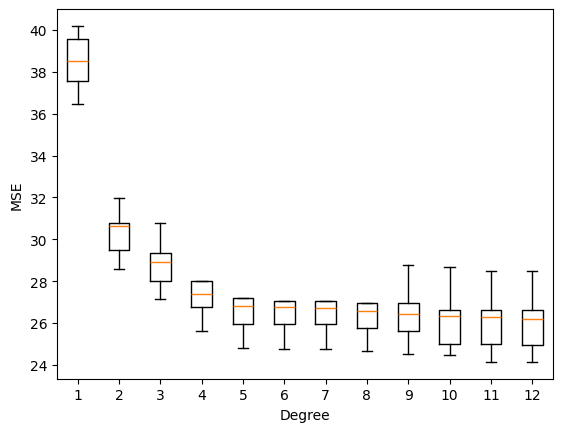

In [267]:
plt.boxplot(error_train.values(), showfliers=False)
plt.xlabel("Degree")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

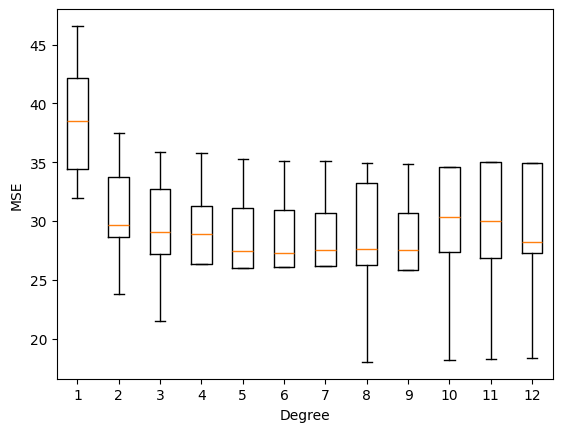

In [268]:
plt.boxplot(error_val.values(),showfliers=False)
plt.xlabel("Degree")
plt.ylabel("MSE")

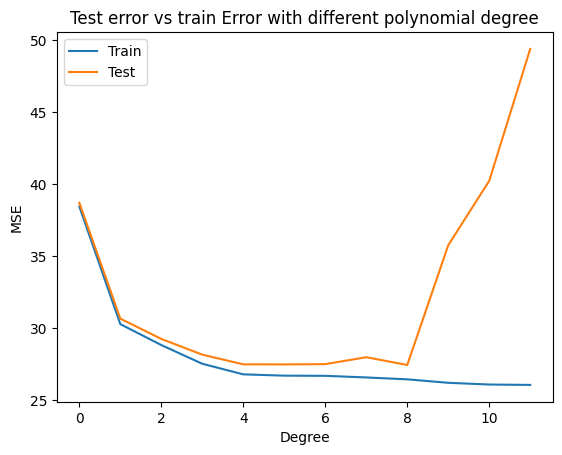

In [269]:
mse_mean_train = []
mse_mean_test = []
for model_name, val in error_train.items():
  mse_mean_train.append(np.mean(val))

for model_name, val in error_val.items():
  mse_mean_test.append(np.mean(val))

plt.plot(mse_mean_train, label="Train")
plt.plot(mse_mean_test, label="Test")
plt.xlabel("Degree")
plt.ylabel("MSE")
plt.title("Test error vs train Error with different polynomial degree")
plt.legend()

Text(0, 0.5, 'Price')

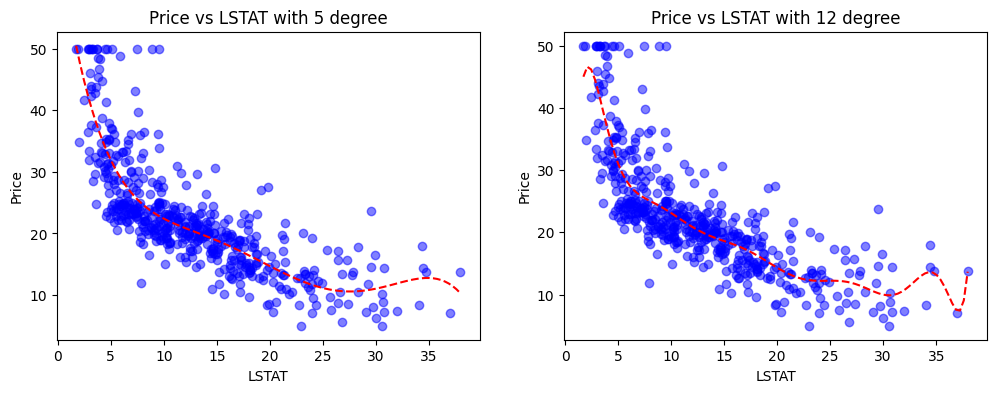

In [271]:
model_name1 = "poly5"
model_name2 = "poly12"
x_model = np.linspace(start=min(l[12]), stop=max(l[12]), num=100).reshape([100])
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].scatter(l[12], target, color="blue", alpha=0.5)
ax[0].plot(x_model, models[model_name1].predict(x_model.reshape([100,1])), color="red", linestyle="--")
ax[0].set_title("Price vs LSTAT with 5 degree")
ax[0].set_xlabel("LSTAT")
ax[0].set_ylabel("Price")

ax[1].scatter(l[12], target, color="blue", alpha=0.5)
ax[1].plot(x_model, models[model_name2].predict(x_model.reshape([100,1])), color="red", linestyle="--")
ax[1].set_title("Price vs LSTAT with 12 degree")
ax[1].set_xlabel("LSTAT")
ax[1].set_ylabel("Price")

In [272]:
model_names = [model_name for model_name in models.keys()]
coefs = []
for model_name in model_names:
  coefs.append(models[model_name][-1].coef_)

coefs_df = pd.DataFrame(coefs).transpose()
coefs_df.columns = model_names
coefs_df

,poly1,poly2,poly3,poly4,poly5,poly6,poly7,poly8,poly9,poly10,poly11,poly12
0,-6.87771,-16.533182,-27.176325,-51.480615,-87.333990,-106.480047,-102.919011,-41.115497,117.591578,269.455878,7.934437e+02,7.463223e+02
1,NaN,10.056772,34.203855,122.386024,309.081539,441.897302,410.767294,-248.230999,-2266.308820,-4503.469831,-1.329931e+04,-1.221769e+04
2,NaN,NaN,-14.292394,-127.393572,-516.681822,-913.763845,-790.734734,2496.252087,14837.795587,31041.870877,1.048908e+05,9.271606e+04
3,NaN,NaN,NaN,49.287655,417.280057,1025.827125,759.031937,-8638.435324,-53325.606016,-124556.425175,-5.078339e+05,-4.241151e+05
4,NaN,NaN,NaN,NaN,-130.025466,-595.673847,-270.138447,15870.500018,117350.128616,319849.913859,1.634738e+06,1.255694e+06
5,NaN,NaN,NaN,NaN,NaN,140.594927,-68.545691,-16486.941705,-162184.863286,-541885.892593,-3.603235e+06,-2.433271e+06
6,NaN,NaN,NaN,NaN,NaN,NaN,54.944799,9154.138070,137350.793479,603150.355867,5.459699e+06,2.962202e+06
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2113.693563,-65102.774518,-424219.853562,-5.586532e+06,-1.906609e+06
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13215.884610,170857.194458,3.683558e+06,1.582844e+04
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-30010.561807,-1.411211e+06,9.462062e+05


# Regularization

In [273]:
# We will use Ridge Regresstion with alpha = 0.001
alpha = 0.001

In [274]:
error_train = dict()
error_val = dict()
poly = dict()
models = dict()

In [275]:
generate_model(alpha=alpha)

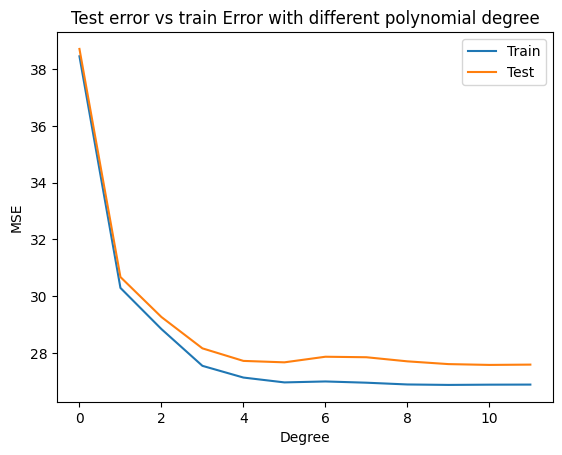

In [276]:
mse_mean_train = []
mse_mean_test = []
for model_name, val in error_train.items():
  mse_mean_train.append(np.mean(val))

for model_name, val in error_val.items():
  mse_mean_test.append(np.mean(val))

plt.plot(mse_mean_train, label="Train")
plt.plot(mse_mean_test, label="Test")
plt.xlabel("Degree")
plt.ylabel("MSE")
plt.title("Test error vs train Error with different polynomial degree")
plt.legend()

Text(0, 0.5, 'Price')

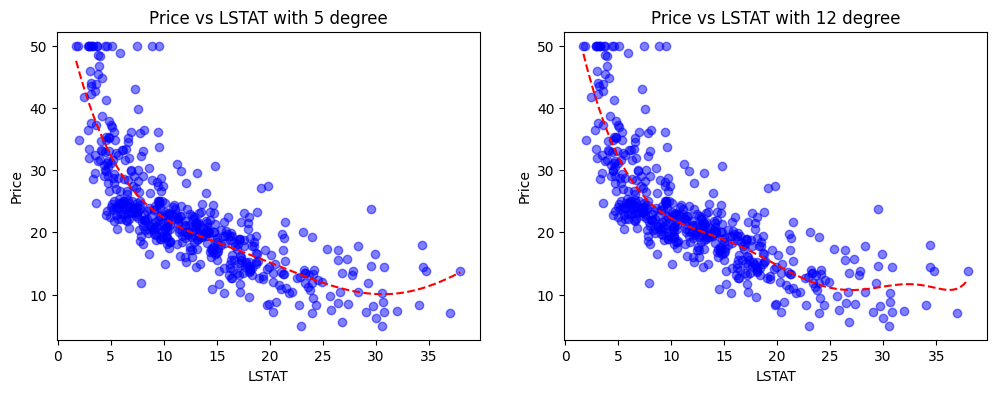

In [277]:
model_name1 = "poly5"
model_name2 = "poly12"
x_model = np.linspace(start=min(l[12]), stop=max(l[12]), num=100).reshape([100])
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].scatter(l[12], target, color="blue", alpha=0.5)
ax[0].plot(x_model, models[model_name1].predict(x_model.reshape([100,1])), color="red", linestyle="--")
ax[0].set_title("Price vs LSTAT with 5 degree")
ax[0].set_xlabel("LSTAT")
ax[0].set_ylabel("Price")

ax[1].scatter(l[12], target, color="blue", alpha=0.5)
ax[1].plot(x_model, models[model_name2].predict(x_model.reshape([100,1])), color="red", linestyle="--")
ax[1].set_title("Price vs LSTAT with 12 degree")
ax[1].set_xlabel("LSTAT")
ax[1].set_ylabel("Price")

In [278]:
model_names = [model_name for model_name in models.keys()]
coefs = []
for model_name in model_names:
  coefs.append(models[model_name][-1].coef_)

coefs_df = pd.DataFrame(coefs).transpose()
coefs_df.columns = model_names
coefs_df

,poly1,poly2,poly3,poly4,poly5,poly6,poly7,poly8,poly9,poly10,poly11,poly12
0,-6.877693,-16.532356,-27.149806,-50.302611,-61.933575,-65.313800,-63.423163,-64.485826,-65.973083,-66.085952,-65.579845,-65.292251
1,NaN,10.055953,34.146081,118.256021,180.690060,181.555179,168.338552,173.542573,178.100263,175.603766,171.686250,170.026206
2,NaN,NaN,-14.259323,-122.253762,-255.738639,-198.516093,-166.466662,-173.352439,-170.467832,-157.747483,-148.426396,-145.610612
3,NaN,NaN,NaN,47.104024,175.871642,9.134025,-7.875282,-13.423660,-33.512494,-46.300423,-48.898738,-48.247902
4,NaN,NaN,NaN,NaN,-46.254229,132.679435,84.884539,97.694692,96.968085,80.932742,69.263248,65.955154
5,NaN,NaN,NaN,NaN,NaN,-67.101438,7.834616,21.798228,56.247410,67.512853,64.119897,61.001915
6,NaN,NaN,NaN,NaN,NaN,NaN,-30.905579,-65.481938,-43.077156,-9.445678,3.575315,4.816797
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.110200,-68.964571,-57.971349,-38.511719,-32.708220
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.100542,-38.963330,-38.491302,-32.579365
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.892794,-7.708632,-9.606064


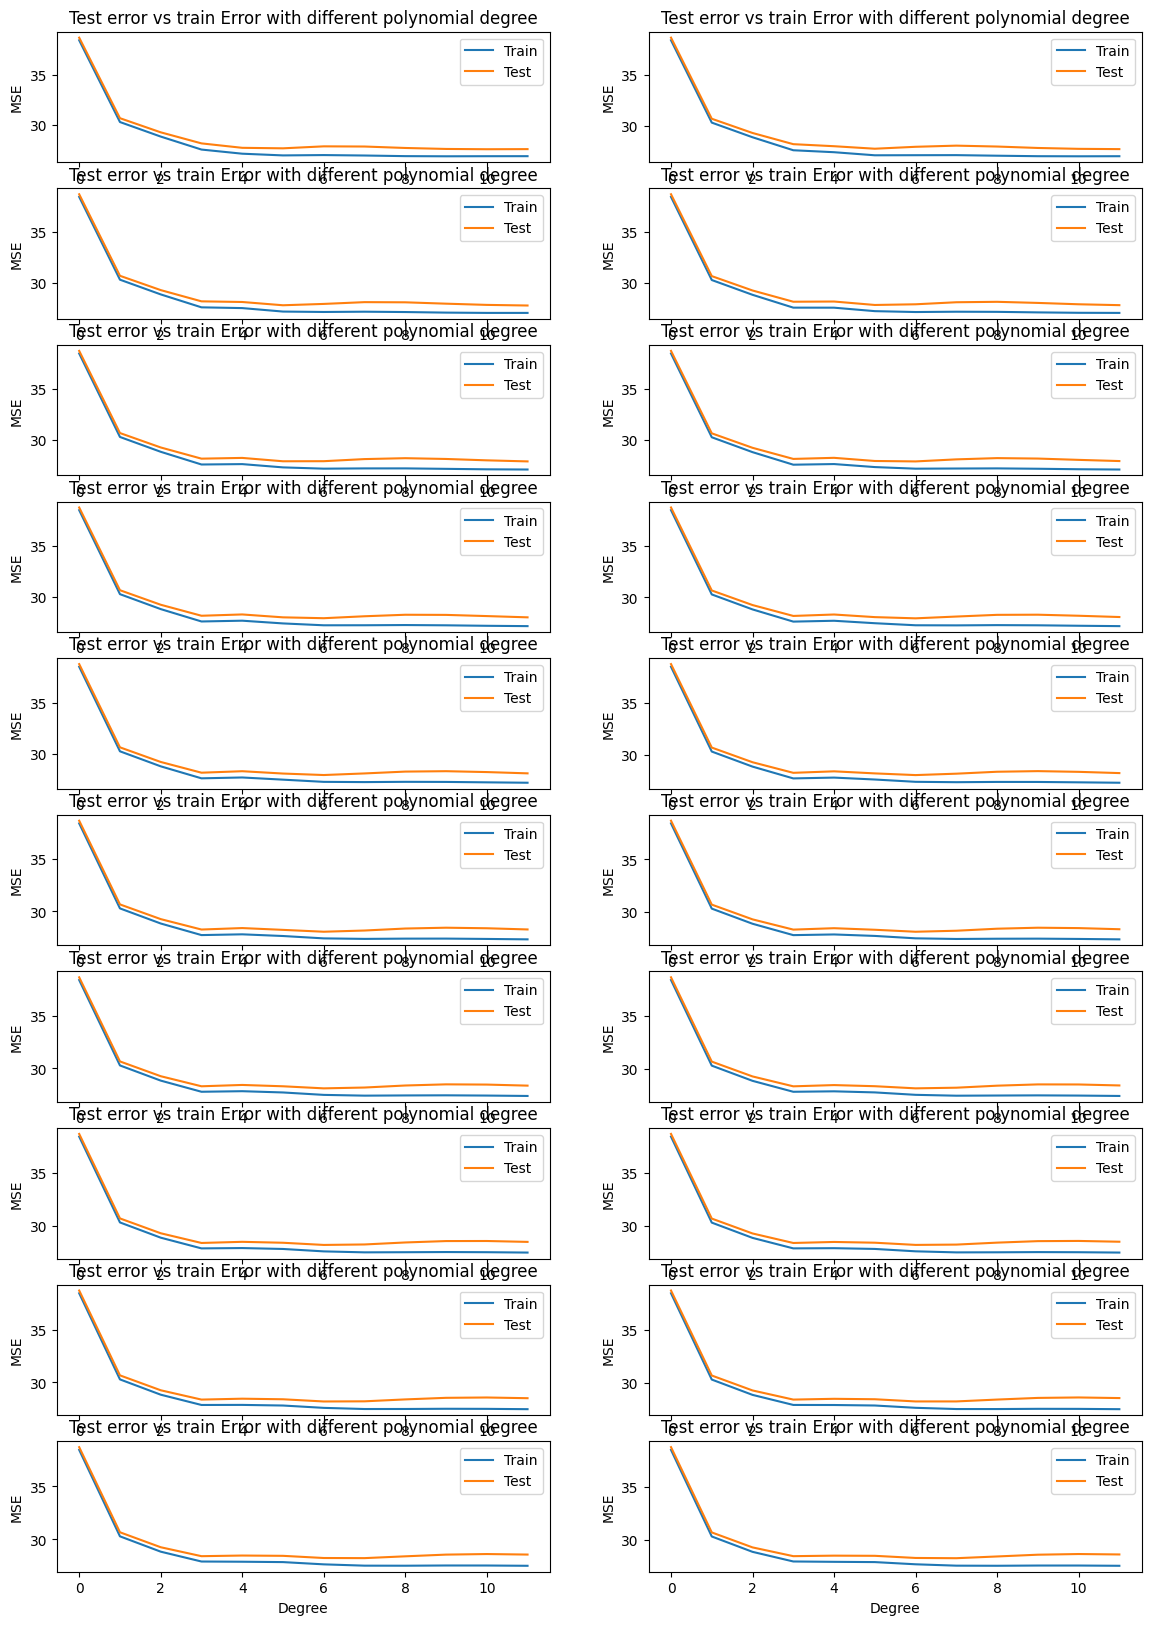

In [291]:
# compare result with changing alpha
fig, ax = plt.subplots(10,2, figsize=(14,20))
for i in range(20):
  error_train = dict()
  error_val = dict()
  poly = dict()
  models = dict()
  alpha = 0.001 * (i+1)
  generate_model(alpha=alpha)
  mse_mean_train = []
  mse_mean_test = []
  for model_name in error_train.keys():
    mse_mean_train.append(np.mean(error_train[model_name]))
    mse_mean_test.append(np.mean(error_val[model_name]))

  ax[i//2, i%2].plot(mse_mean_train, label="Train")
  ax[i//2, i%2].plot(mse_mean_test, label="Test")
  ax[i//2, i%2].set_xlabel("Degree")
  ax[i//2, i%2].set_ylabel("MSE")
  ax[i//2, i%2].set_title("Test error vs train Error with different polynomial degree")
  ax[i//2, i%2].legend()